In [7]:
from tqdm.auto import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from pyprojroot.here import here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
from ipynb.fs.full.shap_utils import load_shap_statistics

In [8]:
CELL_TYPES=["Mono", "T_CD4_Naive", "T_CD4_NonNaive", "T_CD8_Naive", "T_CD8_NonNaive", "B", "Plasma", "UTC", "ILC", "pDC", "DC"]
DISEASES = np.array(['BRCA', 'CD', 'COPD', 'COVID', 'CRC', 'HBV', 'HIV', 'HNSCC', 'MS', 'NPC', 'PS', 'PSA', 'RA', 'SLE', 'UC', 'asthma', 'cirrhosis', 'flu', 'healthy', 'sepsis'])

In [12]:
disease_order = [
    'healthy',
    'CD',
    'MS',
    'PS',
    'PSA',
    'RA',
    'SLE',
    'UC',
    'sepsis',
    'COPD',
    'asthma',
    'cirrhosis',
    'COVID',
    'HBV',
    'HIV',
    'flu',
    'BRCA',
    'CRC',
    'HNSCC',
    'NPC']
cell_type_order = [
    'B',
    'Plasma',
    'pDC',
    'DC',
    'Mono',
    'T_CD4_Naive',
    'T_CD4_NonNaive',
    'T_CD8_Naive',
    'T_CD8_NonNaive',
    'UTC',
    'ILC']

In [ ]:
def rank_heatmap(gene_name, savefig=False):
    ranks = {}
    for cell_type in tqdm(CELL_TYPES):
        adata = ad.read_h5ad(here(f'03_downstreamAnalyses/05_SHAP/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed='r')
        symbols_df = pd.read_pickle(here('03_downstreamAnalyses/04_selected_gene_list.pkl'))
        symbols_sorted = symbols_df.loc[adata.var_names].symbol.values

        # Load SHAP statistics
        _, _, mean_abs, _ = load_shap_statistics(cell_type, interactions=False)

        # Select genes expressed in at least 5% of cells in the selected cell_type
        perc_gene_expr = pd.read_csv(here('03_downstreamAnalyses/05_SHAP/data/genes_expressing_cells.csv'))
        perc_gene_expr = perc_gene_expr.astype({'symbol': 'str', '% cells': 'float', 'CellType': 'category'})
        well_expressed_symbols = perc_gene_expr.query('`% cells` > 5 & CellType == @cell_type').symbol
        symbol_mask = symbols_sorted.isin(well_expressed_symbols)

        # Extract selected gene idx
        gene_idx = np.nonzero(symbols_sorted[symbol_mask] == gene_name)[0][0]

        # Extract selected gene rank
        invrank, disease_idx = np.nonzero(np.argsort(mean_abs[symbol_mask], 0) == gene_idx)
        invrank = mean_abs[symbol_mask].shape[0] - invrank
        sorted_rank = invrank[np.argsort(disease_idx)]

        ranks[cell_type] = sorted_rank
        
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(
        pd.DataFrame(ranks).assign(Disease=DISEASES).set_index('Disease').reindex(index=disease_order, columns=cell_type_order),
        cmap="coolwarm_r", 
        annot=True, 
        square=True,
        fmt='.0f',
        cbar_kws=dict(shrink=.3),
        ax=ax)
    ax.set_title(gene_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    if savefig:
        fig.savefig(here(f'03_downstreamAnalyses/05_SHAP/results/04_shap/gene_thresholds/rank_heatmap/rank_heatmap_{gene_name}.pdf'), dpi=400, bbox_inches='tight')


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

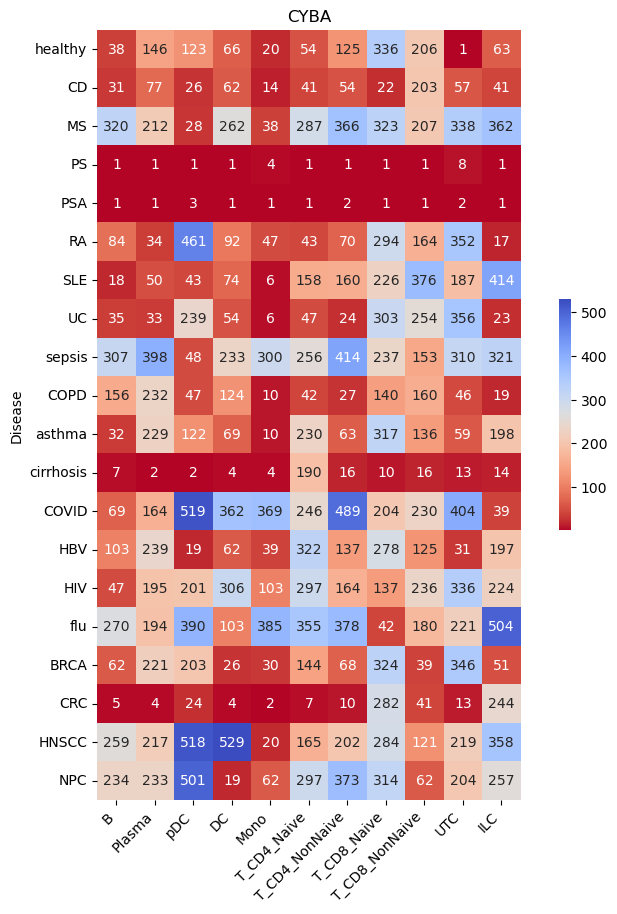

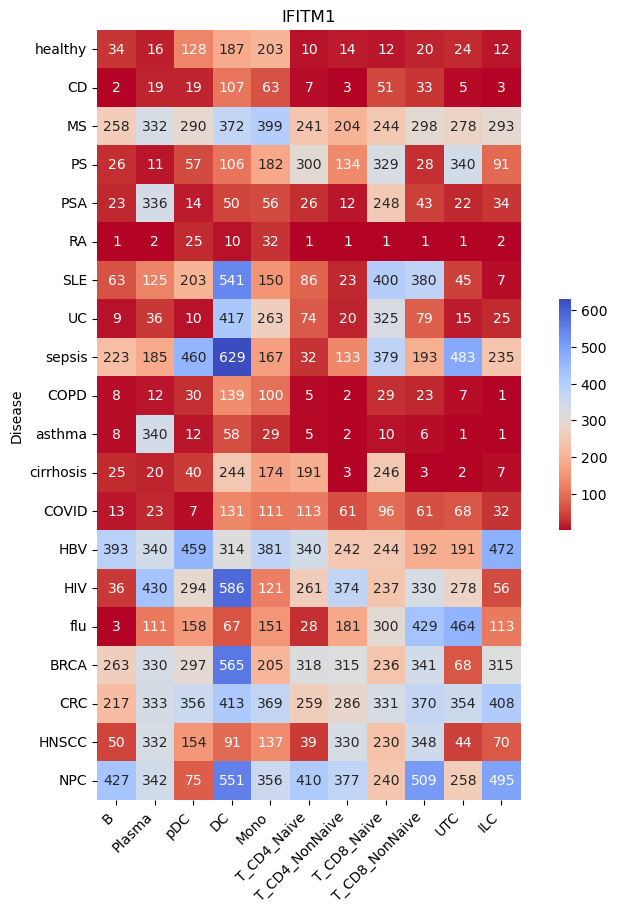

In [14]:
rank_heatmap('CYBA')
rank_heatmap('IFITM1')